*Notebook is a WIP* 

Since T0 variants are big, this notebook uses the HF inference API. You will need to pass an API token to use this. You get a generous free allowance, but you could still burn through this quite quickly if you repeat things many times. `requests_cache` is used to cache requests which means that the same request isn't passed to the API multiple times. 



In [1]:
from datasets import load_dataset
from datasets import concatenate_datasets

In [29]:
def load_datasets():
    en_dataset = load_dataset("bigscience-historical-texts/HIPE2020_sent-split",'en')
    en_dataset = en_dataset.map(lambda x: {"language": "en"})
    fr_dataset = load_dataset("bigscience-historical-texts/HIPE2020_sent-split",'fr')
    fr_dataset = fr_dataset.map(lambda x: {"language": "fr"})
    de_dataset = load_dataset("bigscience-historical-texts/HIPE2020_sent-split",'de')
    de_dataset = de_dataset.map(lambda x: {"language": "de"})
    dataset =  concatenate_datasets([fr_dataset['train'], fr_dataset['validation'], en_dataset['validation'],de_dataset['validation'],de_dataset['train']])
    dataset = dataset.remove_columns([column for column in dataset.features.keys() if column not in ['tokens','id', 'date', "language"]])
    return dataset

In [30]:
dataset = load_datasets()

Downloading:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/99.4k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

Dataset hipe2020 downloaded and prepared to /Users/dvanstrien/.cache/huggingface/datasets/bigscience-historical-texts___hipe2020/en/1.0.0/f1def91947260b00bcde9dc80b6d2fd0867449ecbf2f7e1024bbfd1b56f43118. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset hipe2020 downloaded and prepared to /Users/dvanstrien/.cache/huggingface/datasets/bigscience-historical-texts___hipe2020/fr/1.0.0/f1def91947260b00bcde9dc80b6d2fd0867449ecbf2f7e1024bbfd1b56f43118. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset hipe2020 downloaded and prepared to /Users/dvanstrien/.cache/huggingface/datasets/bigscience-historical-texts___hipe2020/de/1.0.0/f1def91947260b00bcde9dc80b6d2fd0867449ecbf2f7e1024bbfd1b56f43118. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [31]:
import requests_cache

session = requests_cache.CachedSession('HF_API_CACHE',allowable_methods=('GET', 'POST'))

In [1]:
TOKEN = ""

In [33]:
API_URL = "https://api-inference.huggingface.co/models/bigscience/T0"
headers = {"Authorization": f"Bearer {TOKEN}"}

def query(payload):
    response = session.post(API_URL, headers=headers, json=payload)
    return response


In [34]:
text = "It was the best of times, it was the worst of times"

In [35]:
query({"inputs": f"In which year is the following text likely to have been published: text:{text}"}).json()

[{'generated_text': '1812'}]

In [36]:
import re
year_regex = re.compile(r"(\d{4})")
match = year_regex.search("1880s")
match.group()

'1880'

In [37]:
def query_year(example):
    text = " ".join(example['tokens'])
    output = query({"inputs": f"In which year is the following text likely to have been published: text:{text}"})
    try:
        generated_text = output.json()[0]["generated_text"]
        year = year_regex.search(generated_text)
        if year is not None:
            return year.group()
        else:
            return generated_text
    except KeyError:
        return str(output)

In [38]:
dataset = dataset.shuffle()

In [40]:
sample_size = 5000

In [43]:
dataset = dataset.select([i for i in range(sample_size)])

In [44]:
dataset = dataset.map(lambda example: {"year_pred": query_year(example)})

0ex [00:00, ?ex/s]

In [45]:
dataset = dataset.filter(lambda x: len(x['year_pred'])==4)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [46]:
dataset

Dataset({
    features: ['id', 'tokens', 'date', 'language', 'year_pred'],
    num_rows: 4986
})

In [47]:
df = dataset.to_pandas()

In [106]:
#df.to_json('results.json')

In [48]:
df['true_year'] = df['date'].dt.year

In [49]:
true_y = df['true_year'].astype(int)
pred_y = df['year_pred'].astype(int)

In [6]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, max_error

In [51]:
mean_absolute_error(true_y, pred_y)

48.418572001604495

In [52]:
median_absolute_error(true_y, pred_y)

38.0

In [7]:
from collections import defaultdict

In [54]:
metrics = defaultdict(list)
for lang in ['en','de','fr']:
    metrics['language'].append(lang)
    sub_df = df[df['language']==lang]
    true_y = sub_df['true_year'].astype(int)
    pred_y = sub_df['year_pred'].astype(int)
    metrics['MAE'].append(mean_absolute_error(true_y, pred_y))
    metrics['Median Absolute Error'].append(median_absolute_error(true_y, pred_y))
    metrics['Max Error'].append(max_error(true_y, pred_y))

In [1]:
import pandas as pd

In [56]:
metrics = pd.DataFrame.from_dict(metrics)

In [138]:
metrics['MAE'] = metrics['MAE'].round(3)

In [139]:
print(metrics.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
language &    MAE &  Median Absolute Error &  Max Error \\
\midrule
      en & 40.476 &                   30.0 &        789 \\
      de & 40.112 &                   32.0 &       1206 \\
      fr & 55.251 &                   48.0 &       2982 \\
\bottomrule
\end{tabular}



/var/folders/tj/54sfzlyj6_573fn82y996grc0000gr/T/ipykernel_12721/3362837598.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(metrics.to_latex(index=False))


WIP/🗑

In [ ]:
df

,id,tokens,date,language,year_pred,true_year,error
0,1540,"[Son, remplaçant, sera, probablement, Frank, C...",1978-09-27,fr,2009,1978,31
1,5431,"[B, .]",1978-10-11,fr,1865,1978,-113
2,141,"[General, St, ., Julien, ,, besides, the, Rati...",1800-10-21,en,1745,1800,-55
3,3493,"[Le, GrasUdanin, donne, les, détails, suivants...",1888-11-01,fr,1912,1888,24
4,1659,"[Es, handelt, sich, um, folgendes, .]",1898-11-07,de,1890,1898,-8
...,...,...,...,...,...,...,...
4981,3880,"[M, ., Pichon, ,, ministre, des, affaires, étr...",1908-01-07,fr,1848,1908,-60
4982,1400,"[Das, alte, Haus, hatte, sich, heute, in, den,...",1888-10-15,de,1890,1888,2
4983,902,"[Thait, Is, what, I, bave, to, say, about, Alf...",1920-07-08,en,1880,1920,-40
4984,2564,"[7, ., Hendrickx, (, Belgien, ), 4, P, .]",1938-08-09,de,1912,1938,-26


In [ ]:
df['error'] = df['year_pred'].astype(int) - df['true_year'].astype(int)

In [ ]:
df['year'] = df.date.dt.year

In [ ]:
df['decade'] = df.year.astype(str).str[:3]+"0"

In [ ]:
df['century'] = df.year.astype(str).str[:2]+"00"

<AxesSubplot:ylabel='decade'>

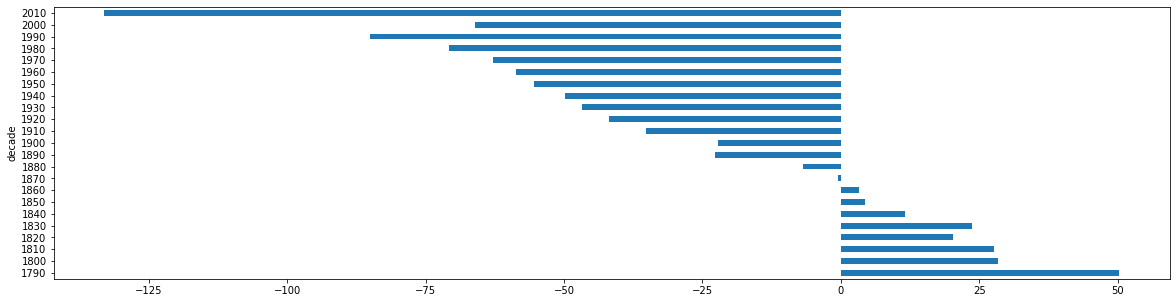

In [ ]:
df.groupby('decade')['error'].mean().plot(kind='barh', figsize=(20,5))

In [17]:
df = pd.read_json('results.json')

In [18]:
df

,id,tokens,date,language,year_pred,true_year,error,year,decade
0,1540,"[Son, remplaçant, sera, probablement, Frank, C...",275702400000,fr,2009,1978,31,1978,1970
1,5431,"[B, .]",276912000000,fr,1865,1978,-113,1978,1970
2,141,"[General, St, ., Julien, ,, besides, the, Rati...",-5339347200000,en,1745,1800,-55,1800,1800
3,3493,"[Le, GrasUdanin, donne, les, détails, suivants...",-2561328000000,fr,1912,1888,24,1888,1880
4,1659,"[Es, handelt, sich, um, folgendes, .]",-2245276800000,de,1890,1898,-8,1898,1890
...,...,...,...,...,...,...,...,...,...
4981,3880,"[M, ., Pichon, ,, ministre, des, affaires, étr...",-1956096000000,fr,1848,1908,-60,1908,1900
4982,1400,"[Das, alte, Haus, hatte, sich, heute, in, den,...",-2562796800000,de,1890,1888,2,1888,1880
4983,902,"[Thait, Is, what, I, bave, to, say, about, Alf...",-1561593600000,en,1880,1920,-40,1920,1920
4984,2564,"[7, ., Hendrickx, (, Belgien, ), 4, P, .]",-990835200000,de,1912,1938,-26,1938,1930


In [39]:
metrics = defaultdict(list)
for lang in ['en','de','fr']:
    metrics['language'].append(lang)
    sub_df = df[df['language']==lang]
    true_y = sub_df['true_year'].astype(int)
    pred_y = sub_df['year_pred'].astype(int)
    metrics['MAE'].append(mean_absolute_error(true_y, pred_y).round(2))
    metrics['Median Absolute Error'].append(median_absolute_error(true_y, pred_y))
   #metrics['Max Error'].append(max_error(true_y, pred_y))

In [40]:
metrics = pd.DataFrame.from_dict(metrics)

In [41]:
metrics

,language,MAE,Median Absolute Error
0,en,40.48,30.0
1,de,40.11,32.0
2,fr,55.25,48.0


In [43]:
print(metrics.to_latex())

\begin{tabular}{llrr}
\toprule
{} & language &    MAE &  Median Absolute Error \\
\midrule
0 &       en &  40.48 &                   30.0 \\
1 &       de &  40.11 &                   32.0 \\
2 &       fr &  55.25 &                   48.0 \\
\bottomrule
\end{tabular}

